## Natural Language Processing

Neste exercício faremos todos os pré-processamentos necessários para que sequências de textos possam ser interpretadas por Redes Neurais.

A tarefa que exploraremos é a Classificaćão de Sentimento usando um dataset de revisões de restaurantes (YELP), produtos (Amazon) e filmes (IMDB) [link](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences).

A nossa tarefa consiste em analisar a revisão e classificá-la entre "positiva" ou "negativa".

In [1]:
from rubianets import *

Nosso dataset tem 3 colunas:

- sentence: O texto da revisão
- label: 1 para texto positivo e 0 para negativo
- source: yelp, amazon ou imdb


In [2]:
import pandas as pd

filepath_dict = {'yelp':   'dataset/sentiment/yelp_labelled.txt',
                 'amazon': 'dataset/sentiment/amazon_cells_labelled.txt',
                 'imdb':   'dataset/sentiment/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
df = df.sample(frac=1).reset_index(drop=True)
print(df.shape, df.columns)
df.head(10)

(2748, 3) Index(['sentence', 'label', 'source'], dtype='object')


,sentence,label,source
0,Definitely worth seeing it's the sort of thou...,1,imdb
1,Don't waste your time here.,0,yelp
2,I'd advise anyone to go and see it.,1,imdb
3,Star Trek V The final Frontier is the worst in...,0,imdb
4,Their daily specials are always a hit with my ...,1,yelp
5,I consider this theft.,0,yelp
6,"I love this phone , It is very handy and has a...",1,amazon
7,It dit not work most of the time with my Nokia...,0,amazon
8,Any ring tone..Overall good phone to buy..,1,amazon
9,This one works and was priced right.,1,amazon


Primeiramente, vamos separar nosso dataset de modo que parte dele seja reservado para teste.

In [3]:
def split_data(df):
    perc_train = 0.80
    len_train = int(len(df)*perc_train)
    dataset_train = df.iloc[0:len_train, :-1]
    dataset_test = df.iloc[len_train:, :-1]
    print('Train | Test dataset lenght:', len(dataset_train), len(dataset_test))
    #dataset_train.head()
    return dataset_train, dataset_test

Agora que temos nosso dataset organizado, o primeiro passo é processar o texto para que seja legível por uma Rede Neural

O primeiro passo é gerar o vocabulário a partir da base de treinamento com a classe [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).

Essa classe executa diversas rotinas de pré-processamento úteis, entre elas:

- Remover pontuacões.
- através do parâmetro `num_words`, permite limitar o tamanho do vocabulário, descartando palavras incomuns.
- Normaliza capitalizacao com `lower=True`

Porém, antes de utilizar a classe, vamos remover stopwords do texto.

Stopwords são palavras com serventia apenas sintática, isso é, são irrelevantes para classificar o "sentimento" da sentenca (leia mais sobre stopwords [aqui](https://demacdolincoln.github.io/anotacoes-nlp/posts/pre-processamento-de-textos/#id2)).

In [4]:
import re

def filter_text(otext):
    to_tokenize = '?!"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n0123456789'
    text = re.sub(r'(['+to_tokenize+'])', r' \1 ', otext)
    text = ' '.join([word for word in text.split() if len(word) > 0 and word != ' '])
    #if text != otext: print(text, otext)
    return text
    
def removeSW(otext):
    #Estamos adicionando stopwords manualmente aqui. Também é possível baixá-las do módulo nltk
    text = otext.lower()
    text = filter_text(text)
    alphabet = [chr(let) for let in range(97, 123)]
    stopwords = alphabet + [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "it'll", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    words = [item for item in text.split() if item not in stopwords]
    text = ' '.join(words)
    return text

#Adicione seu código para Excluir todas as stopwords de todos os exemplos de treinamento
data = df.copy()
data['osentence'] = data.sentence
data.loc[:,'sentence'] = data.loc[:,'sentence'].apply(removeSW)
print(data.head())

dataset_train, dataset_test = split_data(data)

                                            sentence  label source  \
0  definitely worth seeing sort thought provoking...      1   imdb   
1                                 don't waste time .      0   yelp   
2                             advise anyone go see .      1   imdb   
3            star trek final frontier worst series .      0   imdb   
4                  daily specials always hit group .      1   yelp   

                                           osentence  
0  Definitely worth seeing it's the sort of thou...  
1                        Don't waste your time here.  
2              I'd advise anyone to go and see it.    
3  Star Trek V The final Frontier is the worst in...  
4  Their daily specials are always a hit with my ...  
Train | Test dataset lenght: 2198 550


Agora podemos gerar o vocabulário e codificar as sentencas

Através do atributo `word_index`, podemos consultar o vocabulário gerado. As primeiras palavras são as mais comuns.

Em seguida, codificamos o dataset de treinamento e de teste

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

def get_tokenizer(serie, num_words, lower=True):
    oov_token = '<OOV>'   # Token usado caso alguma palavra não for encontrada no vocabulário
    to_exclude = '?!"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n0123456789'
    tokenizer = Tokenizer(num_words=num_words, lower=lower, oov_token=oov_token, filters=to_exclude)
    tokenizer.fit_on_texts(serie)
    vocab_size = len(tokenizer.word_index)
    print('Found %d vocab compared to an allowed %d size.' % (vocab_size, num_words))
    print('Word counts: %s' % (list(tokenizer.word_counts.items())[:5]))
    print('Most commom words: %s' % (list(tokenizer.word_index.items())[:5]))
    print('Longest (average / deviation) review: %d (%d / %d)' % (serie.str.len().max(), int(serie.str.len().mean()), int(serie.str.len().std())))
    return vocab_size, tokenizer

O último passo de pré-processamento agora consiste em realizar o padding das sequências.

Para isso, utilizaremos a funcão [`pad_sequences`](https://keras.io/preprocessing/sequence/)

Os principais argumentos dessa funcão são:

- `maxlen`: tamanho da sequência a ser gerada.
- `padding`: 'pre' para adicionar zeros à esquerda e 'post' para adicionar zeros à direita.
- `truncating`: 'pre' para remover palavras no comeco da frase se for maior que o tamanho especificado, 'post' para remover do final

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def use_tokenizer(tokenizer, serie, maxlen, padding, truncating):
    sequences = tokenizer.texts_to_sequences(serie)
    print('\nTokenized:')
    print(serie.iloc[0], sequences[0])
    X = pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=truncating)
    print(X[0])
    return X

def prepare_data(dataset_train, dataset_test, Xcol, ycol, max_vocab_size, maxlen, padding_type, truncating_type, printt=False):
    vocab_size, tokenizer = get_tokenizer(dataset_train.loc[:, Xcol], max_vocab_size)  
    X_train = use_tokenizer(tokenizer, dataset_train.loc[:, Xcol], maxlen, padding_type, truncating_type)
    X_test = use_tokenizer(tokenizer, dataset_test.loc[:, Xcol], maxlen, padding_type, truncating_type)
    y_train = np.array(dataset_train.loc[:, ycol])
    y_test = np.array(dataset_test.loc[:, ycol])
    if printt: print('\nShapes:', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    return X_train, y_train, X_test, y_test, tokenizer

In [7]:
X_train, y_train, X_test, y_test, tokenizer = prepare_data(dataset_train, dataset_test, 'sentence', 'label', 
                                                5000, 500, 'post', 'post', printt=True)
#print(list(tokenizer.word_index.items())[-500:]) # check less frequent words to check if pre processing is ok
#print(list(tokenizer.word_index.items()))
for key in sorted(tokenizer.word_counts):
    print("%s: %s" % (key, tokenizer.word_counts[key]))

Found 4496 vocab compared to an allowed 5000 size.
Word counts: [('definitely', 28), ('worth', 23), ('seeing', 6), ('sort', 3), ('thought', 13)]
Most commom words: [('<OOV>', 1), ('.', 2), (',', 3), ('not', 4), ('good', 5)]
Longest (average / deviation) review: 5732 (51 / 161)

Tokenized:
definitely worth seeing sort thought provoking film forces question threshold loneliness . [67, 90, 442, 819, 190, 1143, 8, 1144, 1145, 1813, 1146, 2]
[  67   90  442  819  190 1143    8 1144 1145 1813 1146    2    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0  

sea: 2
seafood: 4
seal: 1
seamless: 1
seamlessly: 1
sean: 1
searched: 1
season: 2
seasoned: 2
seasoning: 1
seat: 2
seated: 5
seating: 3
second: 6
secondly: 1
seconds: 3
secure: 2
see: 39
seeen: 1
seeing: 6
seem: 6
seemed: 6
seems: 7
seen: 25
selection: 8
selections: 3
self: 6
seller: 3
sells: 1
semi: 1
send: 1
sending: 4
senior: 1
sense: 2
senses: 2
sensibility: 1
sensitivities: 1
sensor: 1
sent: 1
sentiment: 2
seperate: 1
sequel: 2
sequence: 2
sequences: 1
sergeant: 1
series: 9
serious: 4
seriously: 12
serivce: 1
serve: 2
served: 6
server: 11
servers: 3
serves: 2
service: 87
services: 2
serving: 1
set: 8
sets: 3
setting: 5
settings: 1
setup: 2
seuss: 1
several: 11
severe: 1
sewer: 1
sex: 3
sexy: 1
shakespear: 2
shakespears: 1
shall: 1
shallow: 1
shame: 1
shameful: 1
share: 2
sharing: 1
sharp: 2
sharply: 2
shatner: 1
shattered: 1
shawarrrrrrma: 1
shed: 1
sheer: 1
shelf: 1
shelves: 1
shenanigans: 1
shepard's: 1
shield: 1
shifting: 1
shine: 1
shined: 1
shiny: 1
shipment: 1
shipped: 1
shi

Agora que as sentencas estão em um formato favorável, podemos treinar nosso modelo.


Results:

Performance (train/test): 0.95 / 0.77


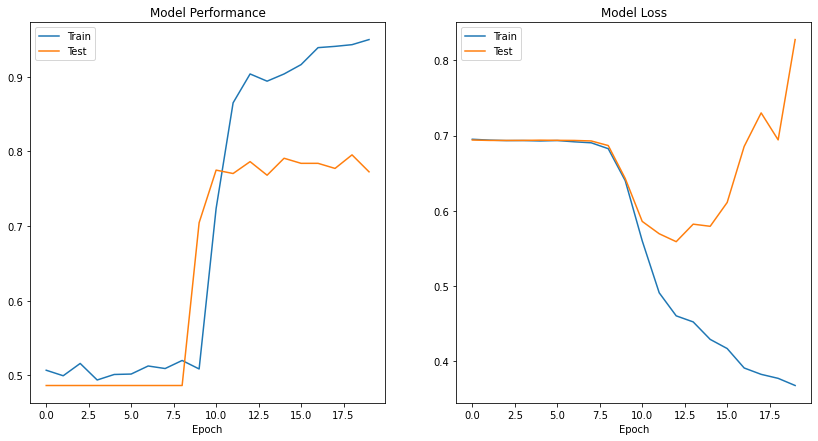

In [8]:
gpu = True
workers = 10
epochs = 20
batch_size = 64

optimizers = {'adam': Adam(lr=1e-4, decay=1e-4/epochs), 'rmsprop': RMSprop(lr=1e-4, rho=0.9, momentum=0.0),
              'sgd': SGD(lr=1e-4, momentum=0.9)}

grid = []
for vs in [1000, 5000]:
    for ed in [2**i for i in [3, 6]]:
        for ml in [200, 500]:
            for pt in ['pre', 'post']: 
                for tt in ['pre', 'post']:
                    for opt in ['adam', 'sgd', 'rmsprop']:
                        grid.append({'max_vocab_size': vs, 'embedding_dim': ed, 'maxlen': ml,
                                     'padding_type': pt, 'truncating_type': tt, 'optimizer': opt})

i = 0
Xcol, ycol = 'sentence', 'label'
results = {}
best_model, best_history, best_accuracy, best_key = None, None, 0, 0

for search in grid:
    X_train, y_train, X_test, y_test, tokenizer = prepare_data(dataset_train, dataset_test, Xcol, ycol, 
                                                    search['max_vocab_size'], search['maxlen'], 
                                                    search['padding_type'], search['truncating_type'], printt=True)

    k = simplerKeras(X=X_train, y=y_train, gpu=gpu, workers=workers)

    model = EmbeddedFive.build(input_dim=search['max_vocab_size'], output_dim=search['embedding_dim'], 
                              input_len=search['maxlen'], classes=2, reg=l2(0.0005), last_act='sigmoid')
    model.compile(loss="binary_crossentropy", optimizer=optimizers[search['optimizer']], metrics=["accuracy"])
    #model.summary()

    start = time.time()
    history = model.fit(k.X, k.y, epochs=epochs, batch_size=batch_size, verbose=0, 
                        validation_split=0.2, workers=k.workers, use_multiprocessing=k.multicore,
                        callbacks=[formatCallbackNotebook(epochs,start)])

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    results[i] = {'max_vocab_size': search['max_vocab_size'], 'embedding_dim': search['embedding_dim'], 
                    'maxlen': search['maxlen'], 'padding_type': search['padding_type'], 
                    'truncating_type': search['truncating_type'], 'optimizer': search['optimizer'],
                    'test_loss': test_loss, 'test_acc': test_acc}

    if test_acc > best_accuracy:
        best_model = model
        best_history = history
        best_accuracy = test_acc
        best_key = i
    i += 1

print('\nResults:')
k.printHistory(best_history.history, metric='accuracy')

In [9]:
df = pd.DataFrame.from_dict(results, orient='index')
df.sort_values(by='test_acc', inplace=True, ascending=False)
df

,max_vocab_size,embedding_dim,maxlen,padding_type,truncating_type,optimizer,test_loss,test_acc
78,5000,64,200,post,pre,adam,0.888104,0.760000
24,1000,64,200,pre,pre,adam,0.599943,0.721818
83,5000,64,200,post,post,rmsprop,0.692695,0.569091
70,5000,8,500,post,post,sgd,0.693691,0.512727
69,5000,8,500,post,post,adam,0.692943,0.512727
...,...,...,...,...,...,...,...,...
30,1000,64,200,post,pre,adam,0.693291,0.512727
29,1000,64,200,pre,post,rmsprop,0.694304,0.512727
28,1000,64,200,pre,post,sgd,0.702037,0.512727
27,1000,64,200,pre,post,adam,0.693237,0.512727


In [10]:
results[best_key]

{'max_vocab_size': 5000,
 'embedding_dim': 64,
 'maxlen': 200,
 'padding_type': 'post',
 'truncating_type': 'pre',
 'optimizer': 'adam',
 'test_loss': 0.8881042636524548,
 'test_acc': 0.76}

# Boosting
Ver loop criado acima, simulando um grid_search. Vamos usar os melhores resultados e refinar o grid.

Avalie como o número de dimensões do embedding, o tipo do padding, o tamanho do vocabulário, o tamanho máximo de sentenca, etc. contribuem para a qualidade do modelo.



Results:

Performance (train/test): 0.87 / 0.80


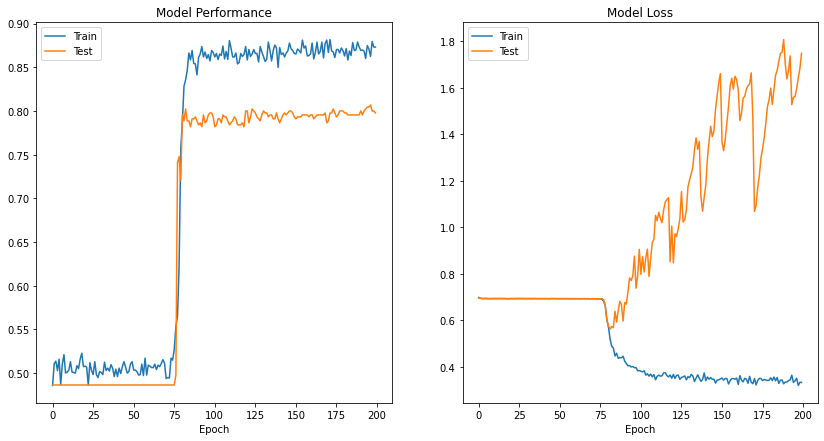

In [17]:
gpu = True
workers = 10
epochs = 200
batch_size = 64

optimizers = {'adam': Adam(lr=1e-4, decay=1e-4/epochs), 'rmsprop': RMSprop(lr=1e-4, rho=0.9, momentum=0.0),
              'sgd': SGD(lr=1e-4, momentum=0.9)}

grid = []
for vs in [5000]:
    for ed in [2**i for i in [4, 6, 8]]:
        for ml in [200, 500, 1000]:
            for pt in ['post']: 
                for tt in ['post']:
                    for opt in ['adam']:
                        grid.append({'max_vocab_size': vs, 'embedding_dim': ed, 'maxlen': ml,
                                     'padding_type': pt, 'truncating_type': tt, 'optimizer': opt})

i = 0
Xcol, ycol = 'sentence', 'label'
results = {}
best_model, best_history, best_accuracy, best_key = None, None, 0, 0

for search in grid:
    X_train, y_train, X_test, y_test, tokenizer = prepare_data(dataset_train, dataset_test, Xcol, ycol, 
                                                    search['max_vocab_size'], search['maxlen'], 
                                                    search['padding_type'], search['truncating_type'], printt=True)

    k = simplerKeras(X=X_train, y=y_train, gpu=gpu, workers=workers)

    model = EmbeddedFive.build(input_dim=search['max_vocab_size'], output_dim=search['embedding_dim'], 
                              input_len=search['maxlen'], classes=2, reg=l2(0.0005), last_act='sigmoid',
                              init='uniform')
    model.compile(loss="binary_crossentropy", optimizer=optimizers[search['optimizer']], metrics=["accuracy"])
    #model.summary()

    start = time.time()
    history = model.fit(k.X, k.y, epochs=epochs, batch_size=batch_size, verbose=0, 
                        validation_split=0.2, workers=k.workers, use_multiprocessing=k.multicore,
                        callbacks=[formatCallbackNotebook(epochs,start)])

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    results[i] = {'max_vocab_size': search['max_vocab_size'], 'embedding_dim': search['embedding_dim'], 
                    'maxlen': search['maxlen'], 'padding_type': search['padding_type'], 
                    'truncating_type': search['truncating_type'], 'optimizer': search['optimizer'],
                    'test_loss': test_loss, 'test_acc': test_acc}

    if test_acc > best_accuracy:
        best_model = model
        best_history = history
        best_accuracy = test_acc
        best_key = i
    i += 1

print('\nResults:')
k.printHistory(best_history.history, metric='accuracy')

In [18]:
df = pd.DataFrame.from_dict(results, orient='index')
df.sort_values(by='test_acc', inplace=True, ascending=False)
df

,max_vocab_size,embedding_dim,maxlen,padding_type,truncating_type,optimizer,test_loss,test_acc
3,5000,64,200,post,post,adam,1.464931,0.772727
2,5000,16,1000,post,post,adam,4.018699,0.758182
0,5000,16,200,post,post,adam,5.647022,0.750909
4,5000,64,500,post,post,adam,2.758954,0.750909
6,5000,256,200,post,post,adam,1.544577,0.741818
1,5000,16,500,post,post,adam,4.473700,0.730909
8,5000,256,1000,post,post,adam,1.312616,0.727273
5,5000,64,1000,post,post,adam,0.692965,0.512727
7,5000,256,500,post,post,adam,0.693106,0.512727


In [19]:
results[best_key]

{'max_vocab_size': 5000,
 'embedding_dim': 64,
 'maxlen': 200,
 'padding_type': 'post',
 'truncating_type': 'post',
 'optimizer': 'adam',
 'test_loss': 1.464931459643624,
 'test_acc': 0.77272725}

550/550 [==============================] - 0s 106us/sample - loss: 0.5476 - accuracy: 0.7855

Performance (train/test): 1.00 / 0.82


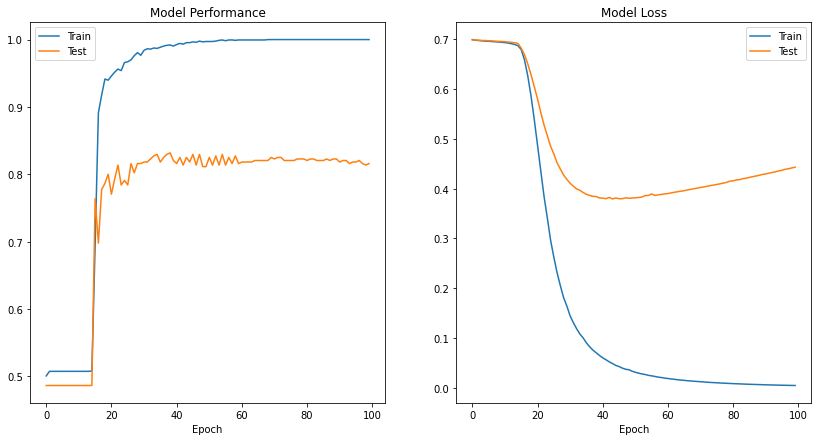

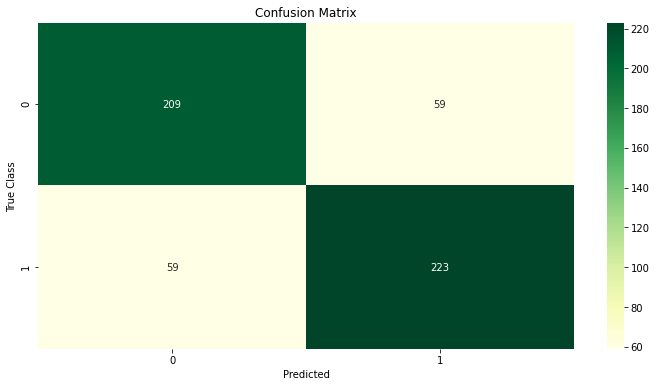

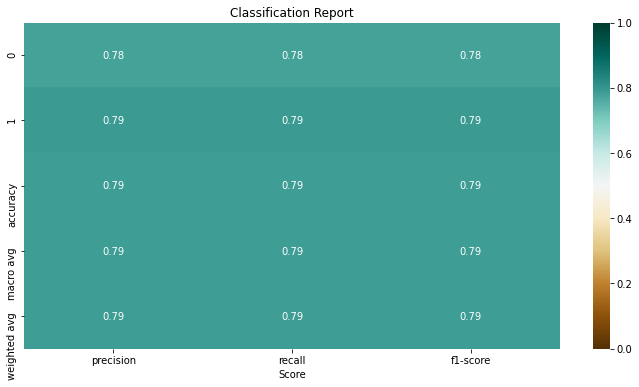

ACCURACY:  78.5 %


In [23]:
gpu = True
workers = 10
epochs = 100
batch_size = 128

optimizers = {'adam': Adam(lr=1e-4, decay=1e-4/epochs), 'rmsprop': RMSprop(lr=1e-4, rho=0.9, momentum=0.0),
              'sgd': SGD(lr=1e-4, momentum=0.9)}

Xcol, ycol = 'sentence', 'label'

X_train, y_train, X_test, y_test, tokenizer = prepare_data(dataset_train, dataset_test, Xcol, ycol, 
                                                5000, 200, 
                                                'post', 'post', printt=True)

k = simplerKeras(X=X_train, y=y_train, gpu=gpu, workers=workers)

model = EmbeddedTwo.build(input_dim=5000, output_dim=128, 
                          input_len=200, classes=2, reg=l2(0.0005), last_act='sigmoid')
model.compile(loss="binary_crossentropy", optimizer=optimizers['adam'], metrics=["accuracy"])
start = time.time()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, 
                    validation_split=0.2, workers=k.workers, use_multiprocessing=k.multicore,
                    callbacks=[formatCallbackNotebook(epochs,start)])

test_loss, test_acc = model.evaluate(X_test, y_test)

k.printHistory(history.history, metric='accuracy')
k.printPerformanceC(X_test, y_test, model=model)

Vamos verificar se as classificacões fazem sentido

In [24]:
or_test_sentences = ['very good movie', 'terrible taste', 'worst product ever']

test_sentences = tokenizer.texts_to_sequences(or_test_sentences)
test_sentences = pad_sequences(test_sentences, maxlen=200, padding='post', truncating='pre')

print(test_sentences)

predictions = model.predict(test_sentences)
print(or_test_sentences)
print(predictions > 0.5)

[[  1   5   7   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [ 78 232   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0  